<a href="https://colab.research.google.com/github/HwangHanJae/datascience-learningnote-titanic/blob/main/titanic_transcription3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #필사에 참고한 링크
[캐글 타이타닉](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410)

# 0. 소개
초급자 레벨의 EDA(탐색적 데이터 분석)와 Feature Engineering에 초점을 맞춘 커널입니다.

다른 커널에 비하여 짧은 커널이며, 초보자에게 좋은 가이드가 되고 새로운 Feature Engineering 아이디어로 영감을 주기 바랍니다.

이 커널에는 3개의 주요 섹션이 있습니다.
- 탐색적 데이터 분석(EDA)
- Random Forest Classifier로 상위 2%(0.83732)공개 순위표 달성
- 전체 노트북 실행시 60초 소모


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings("ignore")

SEED = 42

- 학습 세트에는 891개의 행, 테스트 세트에는 418개의 행이 있습니다.
- 학습 세트에는 12개의 특성, 테스트 세트에는 11개의 특성이 있습니다.
- 학습세트의 추가로 있는 "Survived" 특성이 우리의 타겟입니다.

In [ ]:
def concat_df(train_data, test_data):
  #훈련세트와 테스트세트 concat한 데이터 프레임을 반환
  return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

In [ ]:
def divide_df(all_data):
  #훈련세트와 테스트세트를 divide한 데이터 프레임 2개를 반환
  return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = "Training Set"
df_test.name = "Test Set"
df_all.name = "All Set"

dfs = [df_train, df_test]

print("Number of Training Examples = {} ".format(df_train.shape[0]))
print("Number of Test Examples = {} \n".format(df_test.shape[0]))
print("Training X Shape = {} ".format(df_train.shape))
print("Training y Shape = {}\n".format(df_train["Survived"].shape[0]))
print("Test X Shape = {} ".format(df_test.shape))
print("Test y Shape = {}\n".format(df_test.shape[0]))
print("Training X columns = {} ".format(df_train.columns))
print("Test X columns = {}".format(df_test.columns))

Number of Training Examples = 891 
Number of Test Examples = 418 

Training X Shape = (891, 12) 
Training y Shape = 891

Test X Shape = (418, 11) 
Test y Shape = 418

Training X columns = Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 
Test X columns = Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# 1. EDA(탐색적 데이터 분석)




## 1.1 개요
- PassengerId는 고유 ID이며 타겟에 영향을 주지 않습니다.
- Survived는 타켓이여 예측하려는 변수는 (0 또는 1)입니다.
- Pclass(Passenger Class - 승객등급)는 승객의 사회 경제적 지위이며 3개의 고유한 값(1,2,3)이 있는 범주형 특성입니다.
  - 1 = 상류층
  - 2 = 중산층
  - 3 = 하위층
- Name(이름), Sex(성별), Age(나이) 해석과 동일합니다.
- SibSp는 승객의 형제, 자매, 배우자의 총합입니다.
- Parch는 승객의 부무와 자녀의 총 수 입니다.
- Fare은 승객의 운임(요금)입니다.
- Cabin은 승객의 객실 번호 입니다.
- Embarked는 승선의 항구이며 3개의 고유한 값(C, Q, S)가 있는 범주형 특성입니다.
   - C = Cherbourg
   - Q = Queenstown
   - S = Southampton

In [ ]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
77,78,0,3,"Moutal, Mr. Rahamin Haim",male,NaN,0,0,374746,8.0500,NaN,S
762,763,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C


In [ ]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
376,1268,3,"Kink, Miss. Maria",female,22.0,2,0,315152,8.6625,NaN,S
332,1224,3,"Thomas, Mr. Tannous",male,NaN,0,0,2684,7.2250,NaN,C
251,1143,3,"Abrahamsson, Mr. Abraham August Johannes",male,20.0,0,0,SOTON/O2 3101284,7.9250,NaN,S


## 1.2 결측치

아래에서 볼 수 있듯이 일부 열에서 누락된 값이 있습니다.

display_missing 함수는 학슴 및 테스트 세트의 모든 열에서 누락된 값의 개수를 보여줍니다.

  - 훈련 세트에서 누락된 값이 있는 열은 Age, Cabin 그리고 Emberked 입니다.
  - 테스트 세트에서 누락된 값이 있는 열은 Age, Cabin 그리고 Fare 입니다.

결측치를 처리하는 동안에는 concat한 학습, 테스트세트에서 작업하는 것이 편리합니다.

그렇지 않으면 채워진 데이터가 학습 또는 테스트 세트에 과대적합(overfitting)될 수 있습니다.

Age, Embarked 그리고 Fare 에서 누락된 값의 개수는 전체 샘플에 비해서 적지만, Cabin열은 80%의 값이 누락 되었습니다.

Embarked, Age 그리고 Fare은 통계적 측정값으로 채울 수 있지만 Cabin은 그렇지 않습니다.

In [ ]:
def display_missing(df):
  for col in df.columns.tolist():
    print("{} columns missing values : {}, pct : {}%".format(col, df[col].isnull().sum(), round(df[col].isnull().sum()/len(df[col]),2) * 100))
  print('\n')

In [ ]:
#dfs = [df_train, df_test]
for df in dfs:
  print('{}'.format(df.name))
  display_missing(df)

Training Set
PassengerId columns missing values : 0, pct : 0.0%
Survived columns missing values : 0, pct : 0.0%
Pclass columns missing values : 0, pct : 0.0%
Name columns missing values : 0, pct : 0.0%
Sex columns missing values : 0, pct : 0.0%
Age columns missing values : 177, pct : 20.0%
SibSp columns missing values : 0, pct : 0.0%
Parch columns missing values : 0, pct : 0.0%
Ticket columns missing values : 0, pct : 0.0%
Fare columns missing values : 0, pct : 0.0%
Cabin columns missing values : 687, pct : 77.0%
Embarked columns missing values : 2, pct : 0.0%


Test Set
PassengerId columns missing values : 0, pct : 0.0%
Pclass columns missing values : 0, pct : 0.0%
Name columns missing values : 0, pct : 0.0%
Sex columns missing values : 0, pct : 0.0%
Age columns missing values : 86, pct : 21.0%
SibSp columns missing values : 0, pct : 0.0%
Parch columns missing values : 0, pct : 0.0%
Ticket columns missing values : 0, pct : 0.0%
Fare columns missing values : 1, pct : 0.0%
Cabin columns

### 1.2.1 Age
Age에서 누락된 값은 중간연령(중앙값)으로 채워지지만 전체 데이터 세트의 중간 연령을 사용하는 것은 좋은 선택이 아닙니다.

Pclass 그룹의 중간연령(중앙값) Age(0.408106)및 Survived(0.338481) 높은 상관 관계 때문에 최상의 선택입니다.

Pclass별로 Age를 그룹하는 것이 더 논리적입니다.

In [ ]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_all_corr = df_all_corr.rename(columns={"level_0" : "Feature 1", "level_1" : "Feature 2", 0 : "상관계수"})
df_all_corr.loc[df_all_corr["Feature 1"] == "Age"]

,Feature 1,Feature 2,상관계수
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Pclass와 Sex 그룹은 뚜렷한 중간 연령값을 가지고 있습니다.

Pclass가 증가하면 남녀 모두의 중간연령 값도 증가합니다.

그러나 여성은 남성보다 Age 중앙값이 낮은 경향이 있습니다.

더 정확하게 하기 위하여 누락된 Age 값을 채우는 동안 남녀를 Pclass로 나누어 채우도록 하겠습니다.

In [ ]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()["Age"]
for pclass in range(1,4):
  for sex in ['female', 'male']:
    print("Median age of Pclass {} {}s : {}".format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print("Median age of all passengers : {}".format(df_all['Age'].median()))

df_all["Age"] = df_all.groupby(["Sex","Pclass"])["Age"].apply(lambda x : x.fillna(x.median()))

Median age of Pclass 1 females : 36.0
Median age of Pclass 1 males : 42.0
Median age of Pclass 2 females : 28.0
Median age of Pclass 2 males : 29.5
Median age of Pclass 3 females : 22.0
Median age of Pclass 3 males : 25.0
Median age of all passengers : 28.0


### 1.2.2 Embarked
Embarked는 범주형 특성이며 전체 데이터 세트에 결측치가 2개뿐입니다.

이 두 승객 모두 여성 상류측이며 동일한 티켓 번호를 가지고 있습니다.

그들은 서로를 알고 함께 같은 항구에서 출발했음을 의미합니다.

상류츨 여성 승객의 최빈값은 C (Cherbourg)이지만 반드시 해당 포트에서 승선했음을 의미하지는 않습니다.

In [ ]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


Stone, Mrs. George Nelson (Martha Evelyn)을 검색했을때

Martha Evelyn Stone : Titanic Survivor 페이지에서 그녀가 그녀의 하녀(Amelie Icard)와 함께 S(Southampton)에서 출발했음을 할 수 있습니다.

Embakred에서 결측치는 S로 채워집니다.


In [ ]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

### 1.2.3 Fare
Fare 값이 누락된 승객은 한명 뿐입니다.

Fare는 가족규모(Parch 및 SibSp)및 Pclass 특성과 관련이 있다고 가정 할 수 있습니다.

3등급 티켓이 있고 가족이 없는 남성의 평균 Fare값은 누락된 값을 채우기 위한 논리적인 선택입니다.

In [ ]:
df_all[df_all["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [ ]:
med_fare = df_all.groupby(["Pclass", "Parch","SibSp"])["Fare"].median()[3][0][0]

df_all["Fare"] = df_all["Fare"].fillna(med_fare)

###1.2.4 Cabin

Cabin 특성은 약간 까다롭고 추가 탐색이 필요합니다.

Cabin 기능의 많은 부분이 누락되었으며 일부 Cabin의 생존율이 더 높을 수 있기 떄문에 특성 자체를 완전히 무시할 수 없습니다.

Cabin 값의 첫 글자는 Cabin이 위차한 데크인 것으로 밝혀졌습니다.

이 데크는 주로 한 클래스로 분리되었지만 일부는 여러 클래스에서 사용되었습니다.


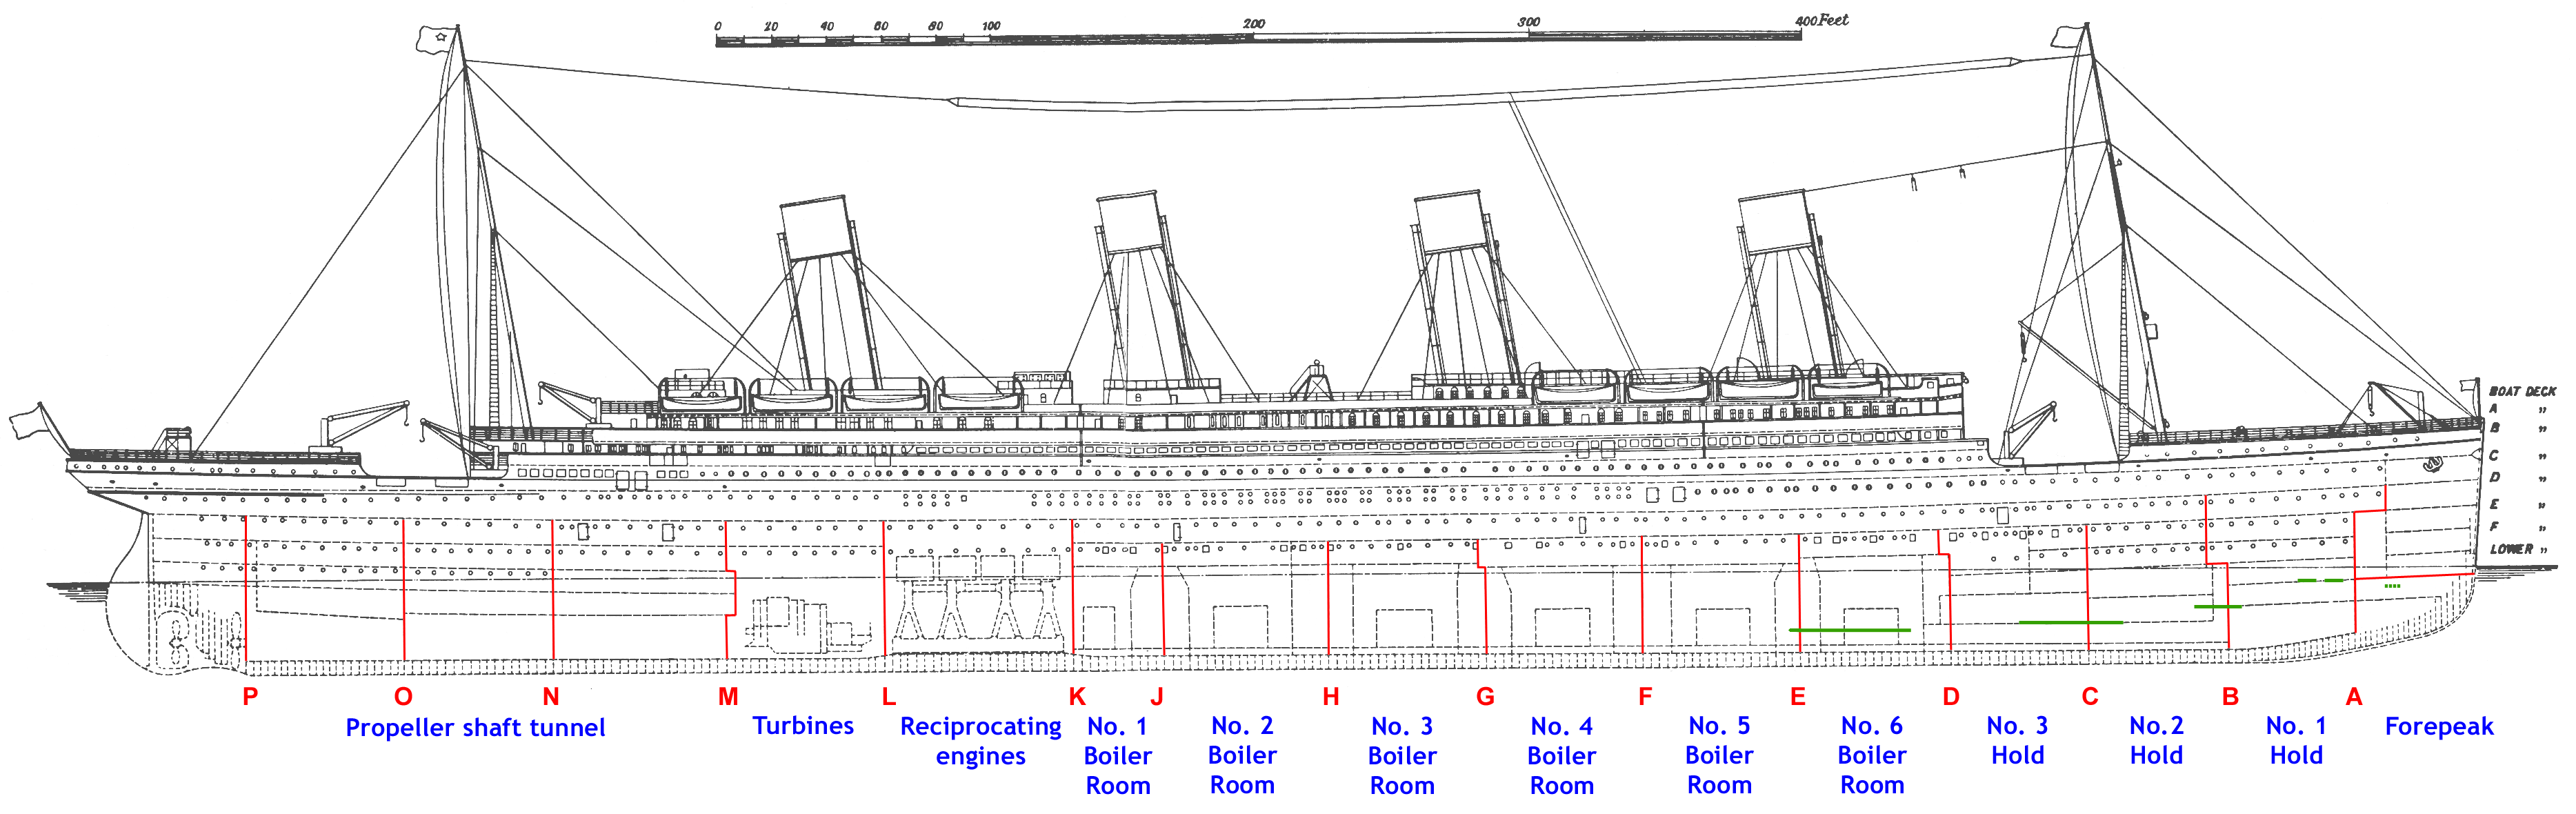

- 보통 데크에는 T, U, W, X, Y, Z로 라벨이 지정이 된 6개의 방이 있었지만 데이터 세트에는 T Cabin만 존재했습니다.
- A, B, C 데크는 1등석 승객전용입니다.
- D, E 데크는 모든 등급을 위한 것입니다.
- F, G 데크는 2등석 및 3등석 승객 모두를 위한 것입니다.
- A에서 G로 이동하면 계단까지의 거리가 증가하여 생존 요인이 될 수 있습니다.

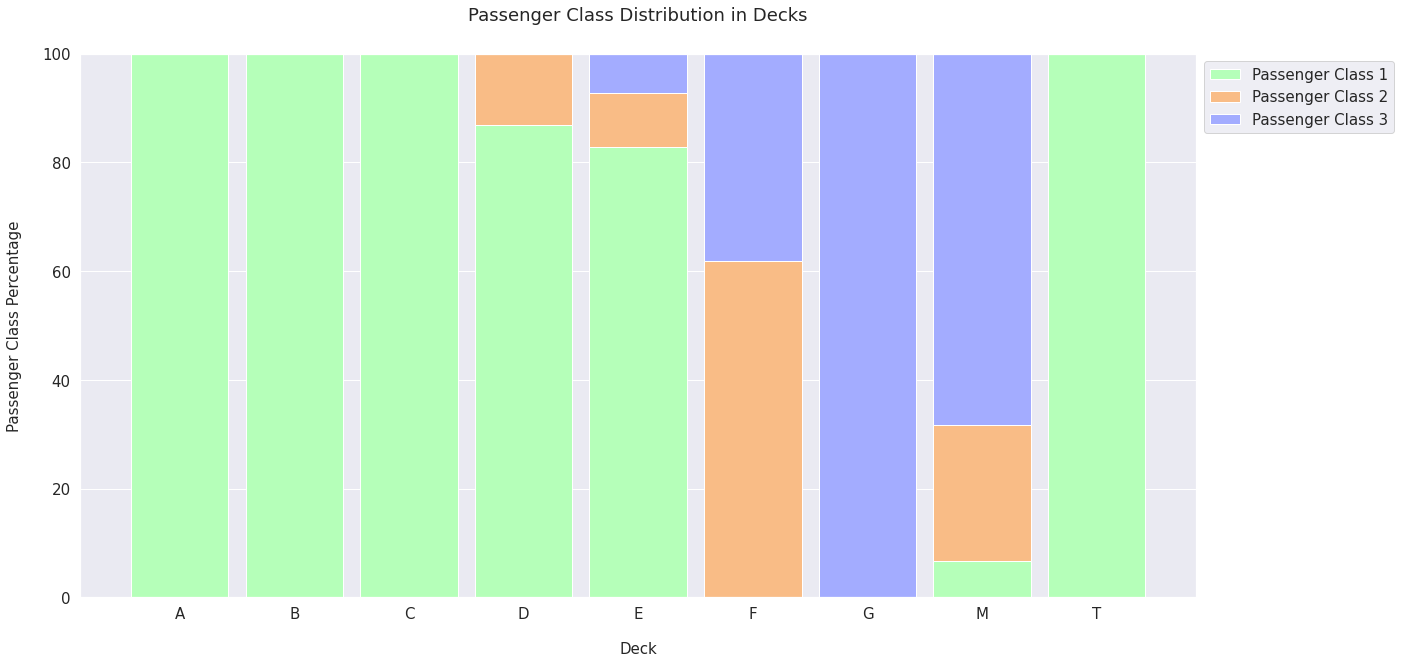

In [ ]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s : s[0] if pd.notnull(s) else "M")
df_all_decks = df_all.groupby(["Deck","Pclass"]).count().drop(columns=["Survived", "Sex", "Age","SibSp","Parch","Embarked","Cabin","PassengerId","Ticket","Fare"]).rename(columns={"Name":"Count"}).transpose()

keyError = KeyError

def get_pclass_dist(df):
  deck_counts = {"A" : {}, "B" :{} , "C" : {}, "D" : {}, "E" : {}, "F" : {}, "G" : {}, "M" : {}, "T" : {}}
  decks = df.columns.levels[0]

  for deck in decks:
    for pclass in range(1,4):
      try:
        count = df[deck][pclass][0]
        deck_counts[deck][pclass] = count
      except keyError:
        deck_counts[deck][pclass] = 0

  df_decks = pd.DataFrame(deck_counts)
  deck_percentages = {}

  for col in df_decks.columns:
    deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

  return deck_counts, deck_percentages



def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    
    plt.show()


all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)


- A, B, C 데크는 100% 1등석 승객입니다.
- D 데크는 1등석 87%, 2등석 13% 탑승입니다.
- E 데크는 1등석 83%, 2등석 10%, 3등석 7% 탑승입니다.
- F 데크는 2등석 62%, 3등석 38% 탑승입니다.
- G 데크는 100% 3등석입니다.
- M 데크는 Cabin 특성에서 누락된 값입니다. 그 승객들의 진짜 데크를 찾을 수 없을 것 같아서 데크처럼 M을 사용하기로 했습니다.
- T 데크는 한명의 승객만 있고, 이 승객은 1등석 승객입니다. A 데크와 가장 유사하므로 A 데크와 그룹화 합니다.


In [ ]:
idx = df_all[df_all["Deck"] == "T"].index
df_all.loc[idx, "Deck"] = "A"

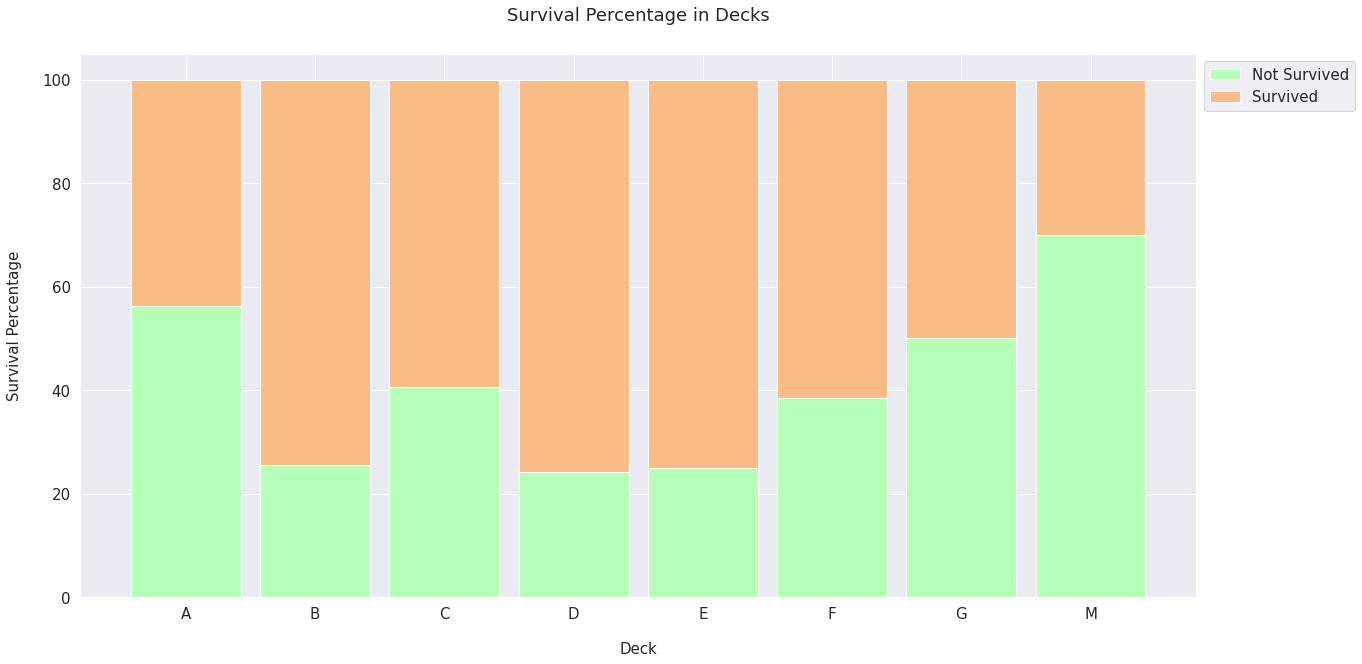

In [ ]:
df_all_decks_survived = df_all.groupby(["Deck", "Survived"]).count().drop(columns=['Sex',"Age","SibSp","Parch","Fare","Embarked","Pclass","Cabin","PassengerId","Ticket"]).rename(columns={"Name":"Count"}).transpose()

def get_survived_dist(df):
  surv_counts ={"A" : {}, "B" :{} , "C" : {}, "D" : {}, "E" : {}, "F" : {}, "G" : {}, "M" : {}}
  decks = df.columns.levels[0]

  for deck in decks:
    for survive in range(0,2):
      surv_counts[deck][survive] = df[deck][survive][0]

  df_surv = pd.DataFrame(surv_counts)

  surv_percentages = {}
  for col in df_surv.columns:
    surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

  return surv_counts, surv_percentages

def display_surv_dist(percentages):

  df_survived_percentages = pd.DataFrame(percentages).transpose()
  deck_names = ("A","B","C","D","E","F","G","M")
  bar_count = np.arange(len(deck_names))
  bar_width=0.85

  not_survived = df_survived_percentages[0]
  survived = df_survived_percentages[1]

  plt.figure(figsize=(20,10))
  plt.bar(bar_count, not_survived, color="#b5ffb9", edgecolor='white',width=bar_width,label="Not Survived")
  plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86',edgecolor='white',width=bar_width,label="Survived")
  plt.xlabel("Deck", size=15, labelpad=20)
  plt.ylabel("Survival Percentage", size=15, labelpad=20)
  plt.xticks(bar_count, deck_names)
  plt.tick_params(axis='both', labelsize=15)

  plt.legend(loc='upper left', bbox_to_anchor=(1,1), prop={'size':15})
  plt.title("Survival Percentage in Decks", size=18, y=1.05)

  plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

모든 데크는 생존율이 다르며 그 정보를 버릴 수 없습니다.

B, C, D 데크 및 E 데크는 생존율이 가장 높습니다.

이 데크는 대부분 1등석 승객이 차지합니다.

M 데크는 2등석과 3등석 승객이 대부분 차지하는 가장 낮은 생존율을 가지고 있습니다.

결론적으로 1등석 승객이 사용하는 객실은 2, 3등석 승객이 사용하는 객실보다 생존율이 높습니다.

M 데크는 피해자의 객실 데이터를 검색 할 수 없기 때문에 생존율이 가장 낮습니다.

그렇기 때문에 해당 그룹을 M으로 표시하는 것이 누락 된 데이터를 처리하는 합리적인 방법이라고 생각합니다.

- A,B,C 데크는 모두 1등 승객만 있기 때문에 ABC로 표시됩니다.
- D, E 데크는 승객분포가 유사하고 생존율이 동일하기 때문에 DE로 표시됩니다.
- F, G 데크도 위와 같은 이유로 FG로 표시됩니다.
- M 데크는 다른 데크과 매우 다르고 생존율이 가장 낮기 때문에 다른 데크와 그룹화 할 필요가 없습니다.




In [ ]:
df_all["Deck"] = df_all["Deck"].replace(["A", "B", "C"], "ABC")
df_all["Deck"] = df_all["Deck"].replace(["D","E"], "DE")
df_all["Deck"] = df_all["Deck"].replace(["F","G"],"FG")

df_all["Deck"].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

Age, Embarked, Fare 및 Deck 기능에서 누락된 값을 채운 후 훈련 및 테스트 세트에 누락된 값이 남아있지 않습니다.

대신 Deck가 사용되어 Cabin이 삭제되었습니다.

In [ ]:
df_all = df_all.drop(["Cabin"], axis=1)

In [ ]:
df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]
for df in dfs:
  display_missing(df)

Age columns missing values : 0, pct : 0.0%
Embarked columns missing values : 0, pct : 0.0%
Fare columns missing values : 0, pct : 0.0%
Name columns missing values : 0, pct : 0.0%
Parch columns missing values : 0, pct : 0.0%
PassengerId columns missing values : 0, pct : 0.0%
Pclass columns missing values : 0, pct : 0.0%
Sex columns missing values : 0, pct : 0.0%
SibSp columns missing values : 0, pct : 0.0%
Survived columns missing values : 0, pct : 0.0%
Ticket columns missing values : 0, pct : 0.0%
Deck columns missing values : 0, pct : 0.0%


Age columns missing values : 0, pct : 0.0%
Embarked columns missing values : 0, pct : 0.0%
Fare columns missing values : 0, pct : 0.0%
Name columns missing values : 0, pct : 0.0%
Parch columns missing values : 0, pct : 0.0%
PassengerId columns missing values : 0, pct : 0.0%
Pclass columns missing values : 0, pct : 0.0%
Sex columns missing values : 0, pct : 0.0%
SibSp columns missing values : 0, pct : 0.0%
Ticket columns missing values : 0, pct : 0

## 1.3 타겟 분포
- 훈련세트의 38.38% (342/891)는 "1" 입니다.
- 훈련세트의 61.62% (549/891)는 "0" 입니다.

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survived and it is the 61.62% of the training set. 



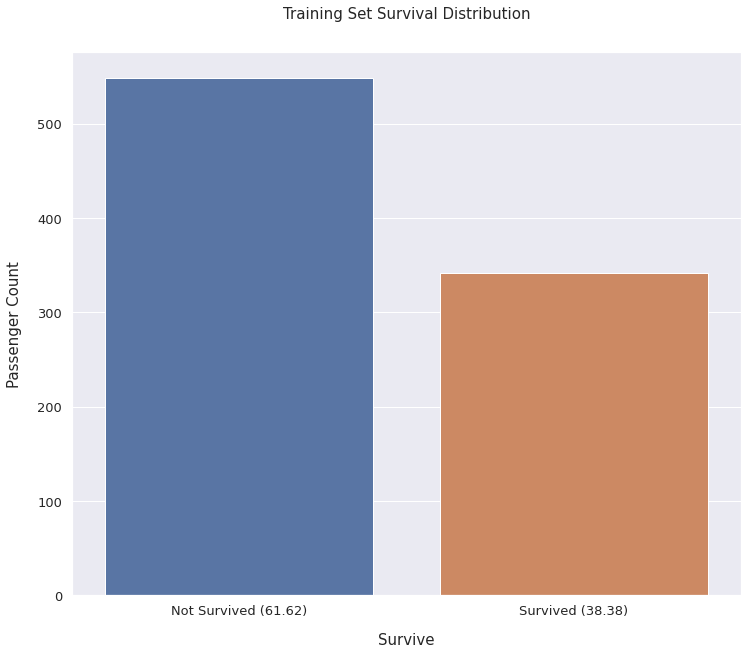

In [ ]:
survived = df_train["Survived"].value_counts()[1]
not_survived = df_train["Survived"].value_counts()[0]
survived_per = (survived / df_train["Survived"].shape[0]) * 100
not_survived_per = (not_survived / df_train["Survived"].shape[0]) * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train["Survived"].shape[0], survived_per))
print('{} of {} passengers didnt survived and it is the {:.2f}% of the training set. \n' .format(not_survived, df_train["Survived"].shape[0], not_survived_per))


plt.figure(figsize=(12,10))
sns.countplot(df_train["Survived"])

plt.xlabel("Survive", size=15, labelpad=15)
plt.ylabel("Passenger Count", size=15, labelpad=15)
plt.xticks((0,1), ["Not Survived ({:.2f})".format(not_survived_per), "Survived ({:.2f})".format(survived_per)])
plt.tick_params('both', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

## 1.4 상관 관계
특성은 서로 높은 상관 관계가 있으며 서로 종속되어 있습니다.

가장 높은 상관 관계는 훈련세트에서 0.549500이고, 테스트 세트에서 0.577147입니다.(Fare와 Pclass)사이

다른 특성도 상관 관계가 높습니다.

0.1보다 높은 상관관계는 훈련세트에서의 10개, 테스트 세트에서 6개의 상관 관계가 있습니다.

In [ ]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_train_corr = df_train_corr.rename(columns={"level_0" : "Feature 1", "level_1" : "Feature 2", 0 : "Correlation Coefficient"})
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr["Correlation Coefficient"] == 1.0].index)

df_test_corr = df_test.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_test_corr = df_test_corr.rename(columns={"level_0" : "Feature 1", "level_1" : "Feature 2", 0 : "Correlation Coefficient"})
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr["Correlation Coefficient"] == 1.0].index)

In [ ]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [ ]:
corr = df_test_corr_nd["Correlation Coefficient"] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Fare,Age,0.345347
12,Parch,SibSp,0.306895
14,Fare,Parch,0.230410
16,Fare,SibSp,0.172032


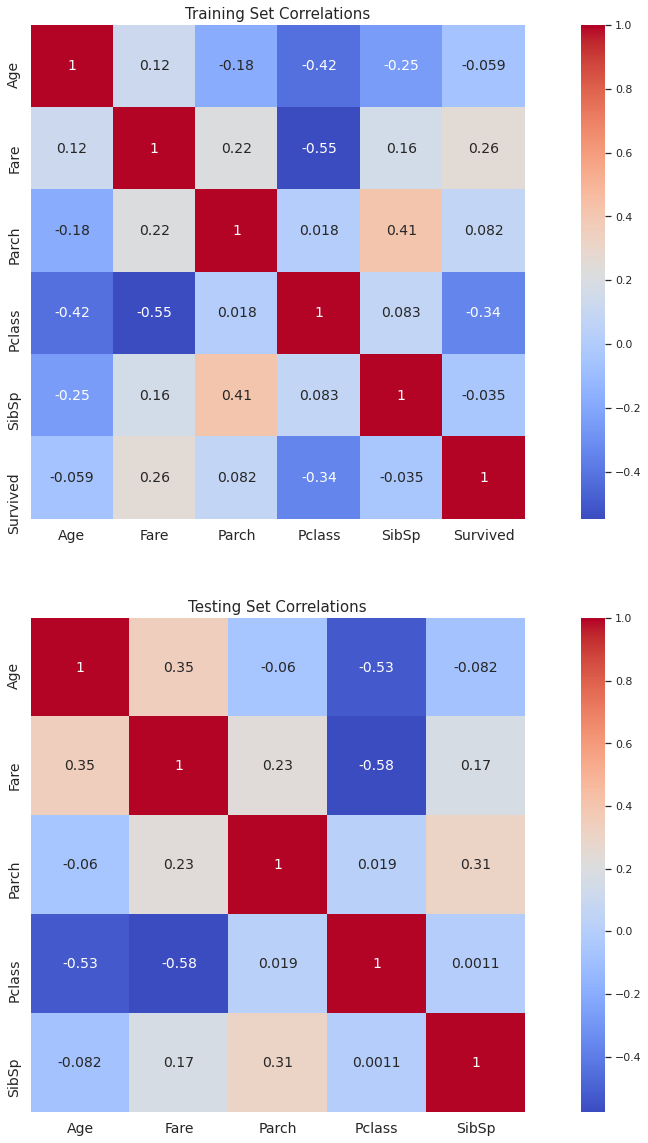

In [ ]:
fig, axe = plt.subplots(nrows=2, figsize=(20,20))
sns.heatmap(df_train.drop("PassengerId", axis=1).corr(), ax=axe[0],annot=True, square=True, cmap='coolwarm', annot_kws={"size":14})
sns.heatmap(df_test.drop("PassengerId", axis=1).corr(), ax=axe[1],annot=True, square=True, cmap='coolwarm', annot_kws={"size":14})

for i in range(2):
  axe[i].tick_params(axis='both', labelsize=14)
axe[0].set_title("Training Set Correlations", size=15)
axe[1].set_title("Testing Set Correlations", size=15)

plt.show()

## 1.5 특성의 타겟 분포


### 1.5.1 연속적인 특성
두 연속 특성(Age & Fare)은 트리가 학습하기 좋은 분할 지점과 스파이크를 가지고 있음

두 연속 특성의 한가지 잠재적인 문제는 분포가 학습 세트에 더 많은 스파이크와 범프가 있지만 테스트 세트에는 조금 더 부드럽다는 것입니다.

이러한 이유로 모델은 테스트 세트를 일반화 할 수 없을 것입니다.

- Age 특성의 분포는 15살 미만의 어린이가 다른 연령대에 비하여 높은 생존율을 가졌다는 것을 분명히 보여줍니다.
- Fare 특성의 분포는 꼬리 부분에 더 높은 생존율을 보여줍니다. 분포는 또한 매우 큰 이상치 때문에 양의 양의 치우침이 있습니다.

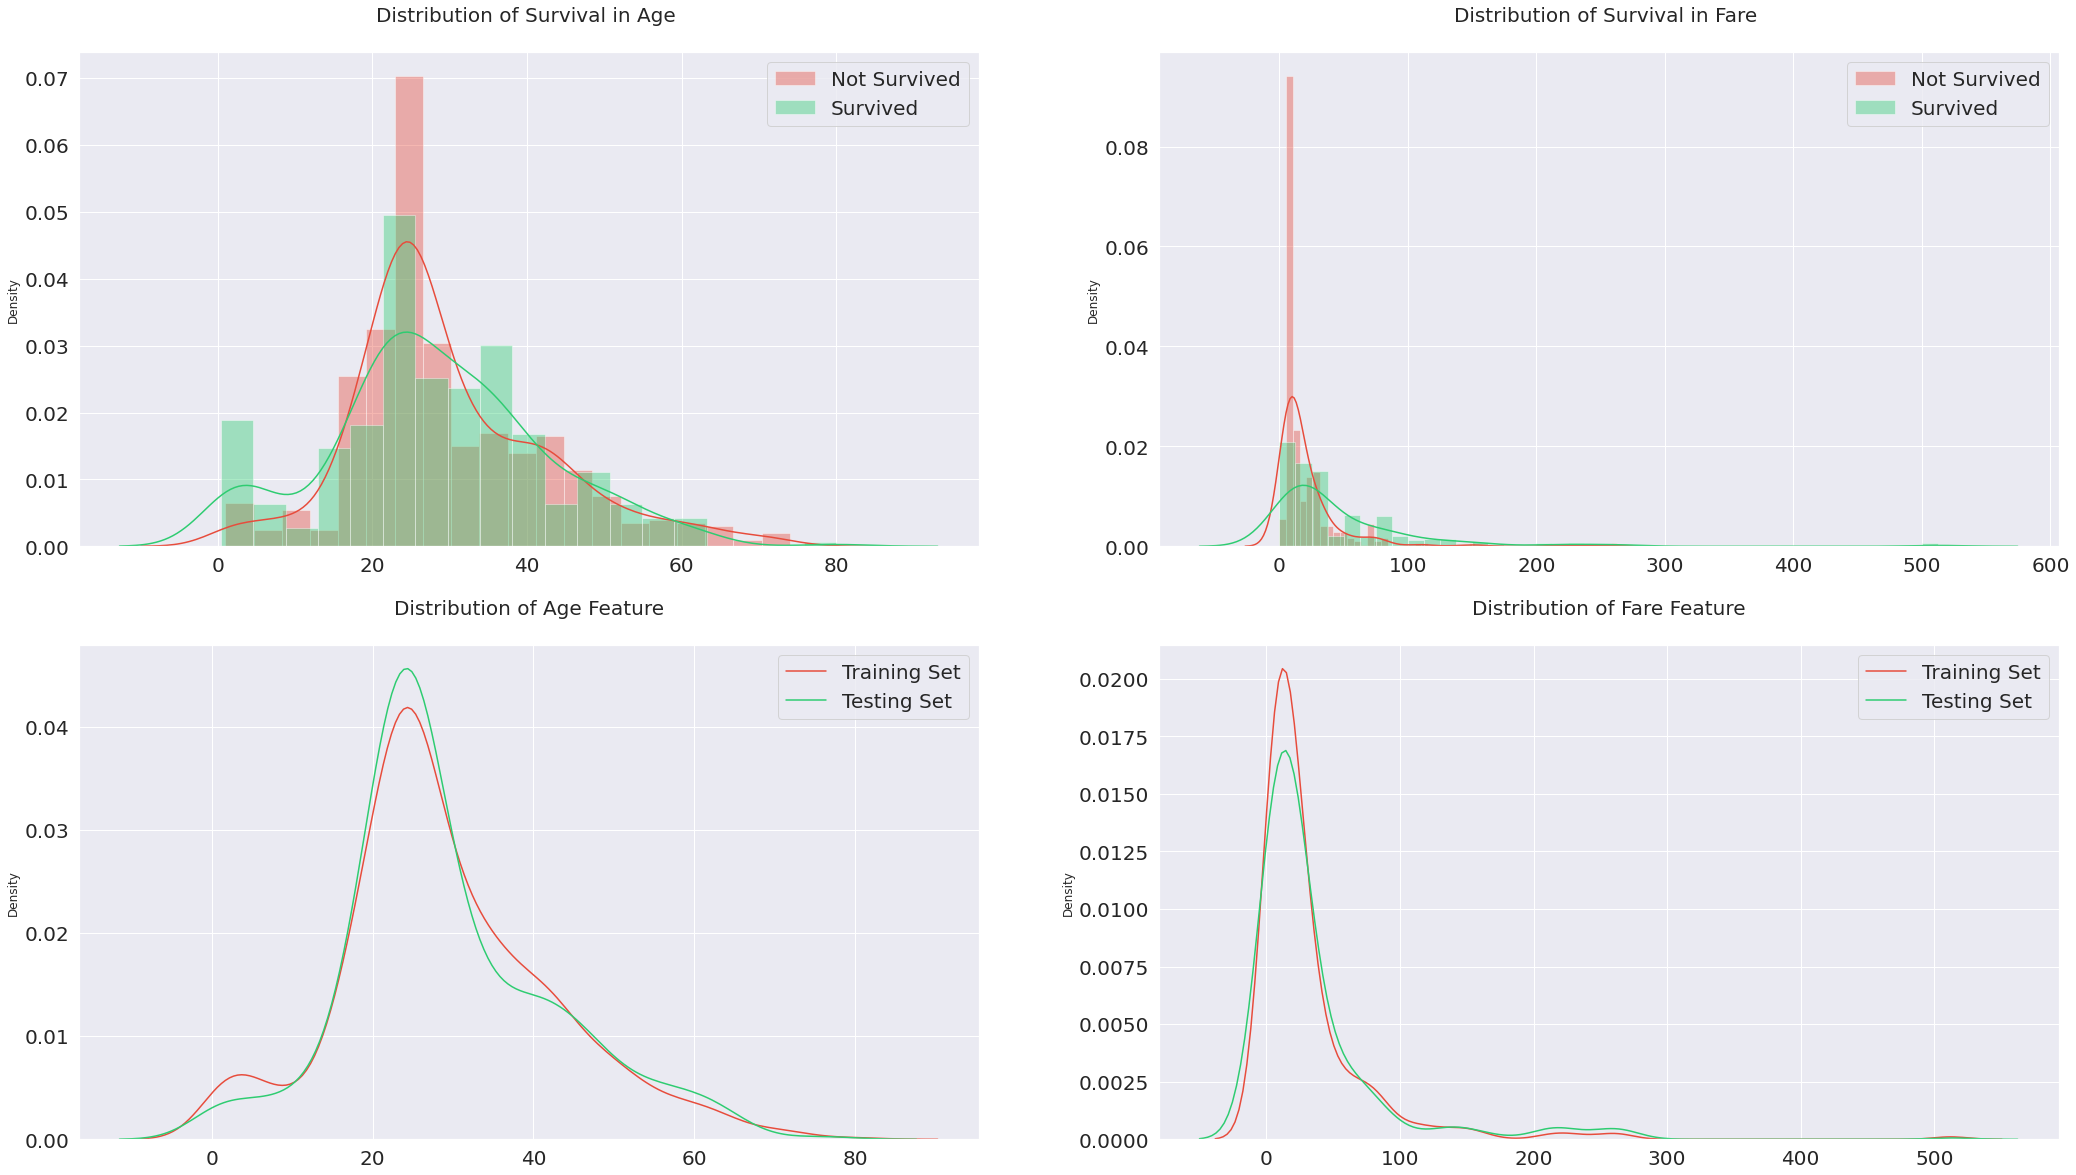

In [ ]:
cont_features = ["Age", "Fare"]
surv = df_train["Survived"] == 1

f, ax = plt.subplots(2,2, figsize=(20,20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
  sns.distplot(df_train[~surv][feature], label="Not Survived",hist=True, color='#e74c3c', ax=ax[0][i])
  sns.distplot(df_train[surv][feature], label="Survived", hist=True, ax=ax[0][i], color='#2ecc71')

  sns.distplot(df_train[feature], label="Training Set", hist=False, color='#e74c3c', ax=ax[1][i])
  sns.distplot(df_test[feature], label="Testing Set", hist=False, color='#2ecc71', ax=ax[1][i])

  ax[0][i].set_xlabel('')
  ax[1][i].set_xlabel('')

  for j in range(2):
    ax[i][j].tick_params(axis='both', labelsize=20)
    
  ax[0][i].legend(loc='upper right', prop={'size' : 20})
  ax[1][i].legend(loc='upper right', prop={'size' : 20})
  ax[0][i].set_title("Distribution of Survival in {} ". format(feature), size=20, y=1.05)

ax[1][0].set_title("Distribution of {} Feature".format("Age"), size=20, y=1.05)
ax[1][1].set_title("Distribution of {} Feature".format("Fare"), size=20, y=1.05)

plt.show()  

### 1.5.2 범주적인 특성
모든 범주적인 특성은 사망률이 높은 클래스가 하나있습니다.

이러한 클래스는 승객이 생존자인지 피해자인지 예측하기에 매우 유용합니다.

가장 균일한 분포를 가지고 있는 Pclass와 Sex 클래스는 최상의 범주적인 특성입니다.

- Southampton에서 탑승한 승객은 다른 포트에서 탑승한 승객보다 낮은 생존율을 가지고 있습니다. Cherbourg에서 탑승한 승객의 절반 이상은 살아남았습니다. 이러한 관찰은 Pclass 특성과 관련이 있을 수 있습니다.
- Parch와 SibSp 특성은 가족 구성원이 한명 뿐인 승객의 생존율이 더 높다는 것을 보여줍니다.

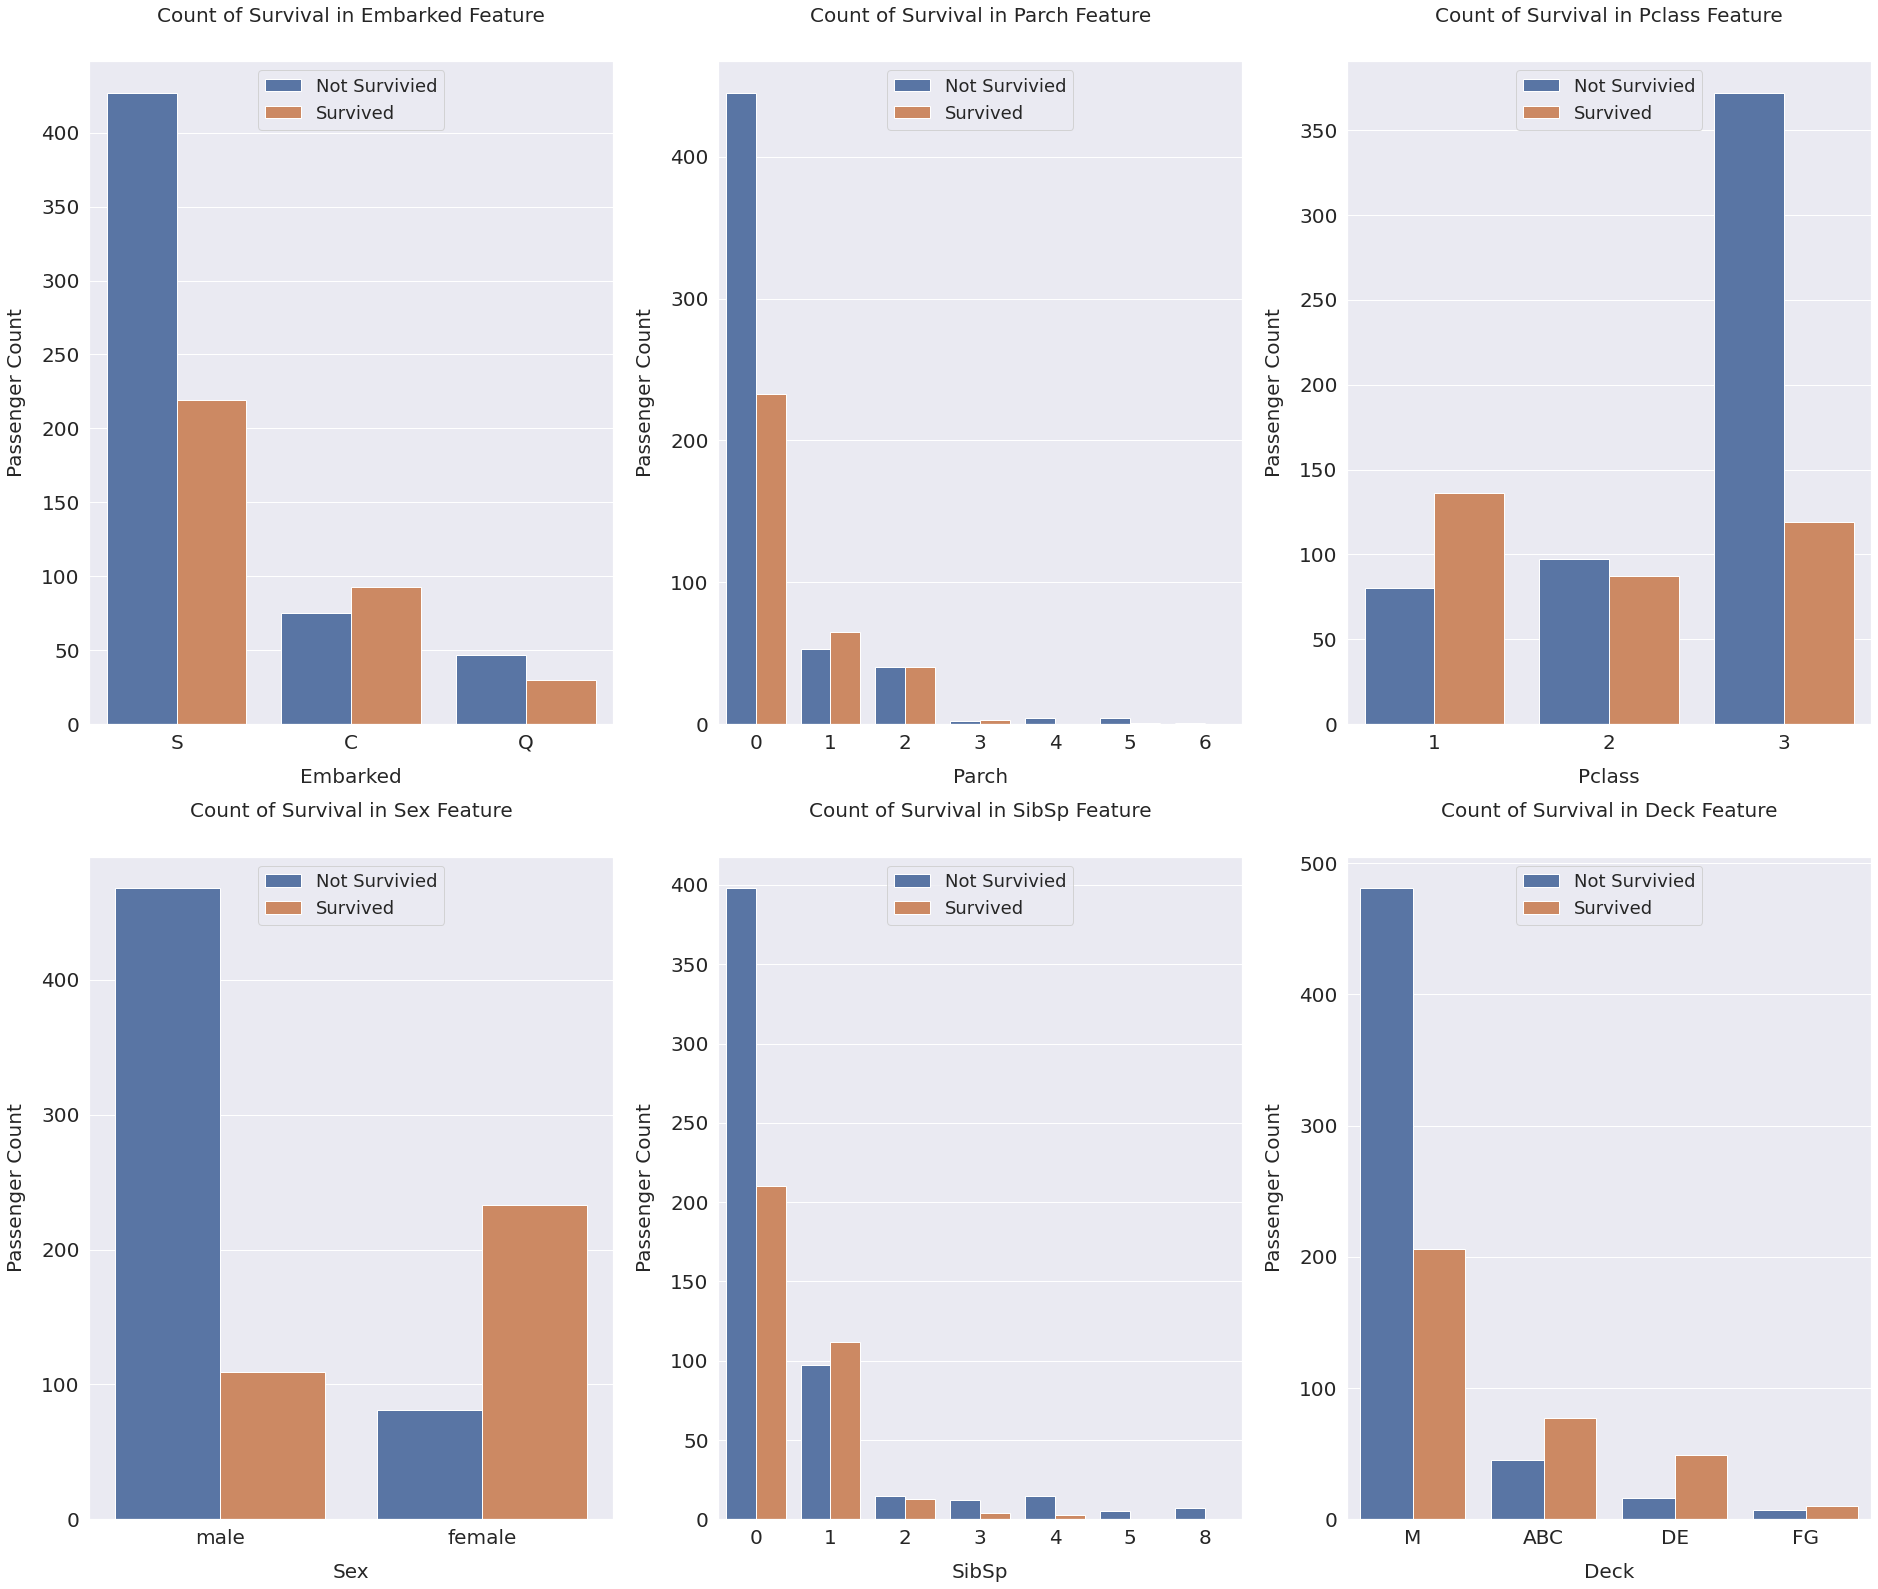

In [ ]:
cat_features = ["Embarked", "Parch", "Pclass", "Sex", "SibSp", "Deck"]

f, ax = plt.subplots(2,3, figsize=(18,18))
plt.subplots_adjust(right=1.5, top=1.25)


for i, feature in enumerate(cat_features, 1): #i가 1부터 시작
  plt.subplot(2,3,i)
  sns.countplot(x=feature, data=df_train, hue='Survived')

  plt.xlabel('{}'.format(feature), size=20, labelpad=15)
  plt.ylabel("Passenger Count", size=20, labelpad=15)
  plt.tick_params('both', labelsize=20)

  plt.legend(["Not Survivied", "Survived"], loc='upper center', prop={"size" : 18})
  plt.title("Count of Survival in {} Feature".format(feature), size=20,y=1.05)
plt.show()

## 1.6 결론
대부분의 특성은 서로 연관 되어 있습니다.

이러한 관계는 특성 변환과 특성 상호작용을 통해 새로운 특성을 만드는데 사용할 수 있습니다.

타겟 인코딩은 Survived 특성과의 높은 상관관계 때문에 매우 유용할 수 있습니다.

연속적인 특성에서 분할 지점과 스파이크가 표시됩니다.

의사 결정 트리 모델에서는 쉽게 찾아낼 수 있겠지만 선형 모델에서는 이를 발견하지 못할 수 있습니다.

범주적인 특성은 생존율이 다른 매우 뚜렷한 분포를 가지고 있습니다.

이러한 특성은 one-hot encoding 이 될 수 있습니다.

이러한 특성 중 일부는 새로운 특성을 만들기 위해 서로 결합 될 수 있습니다.

EDA(탐색적 데이터 분석)에서 Deck 특성을 만들고, Cabin 특성을 제거하였습니다.


In [ ]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
